#  Lab 07 : Reaction-Diffusion Systems

In this lab we will examine a system of equations describing a two-component *reaction-diffusion* system. As its name suggests, this type of system shows up in settings where we have different substances diffusing -- so the system of equations will have diffusive behavior -- and reacting, so the two substances can also react, depending on their relative abundances. The resulting behavior of the system can produce intricate patterns, commonly encountered in nature; including quite complex biological systems, ranging from fingerprints to cellular division. A few examples of this are shown below.

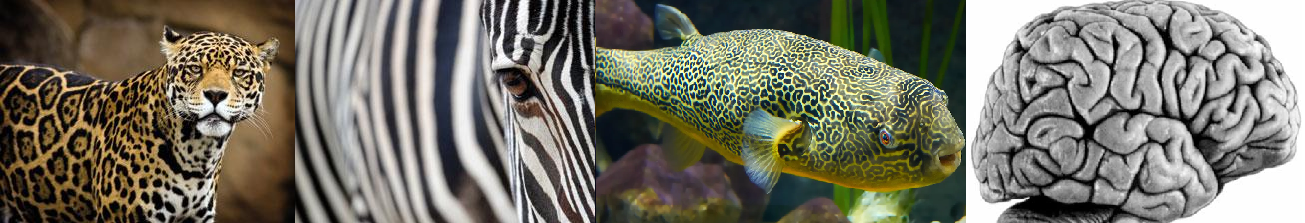


In this lab we will look at the specific example of a system with two substances. We can write equations that describe the concentrations of these substances, which we will call $u(x, y)$ and $v(x, y)$, as

$$
\partial_t u = c_u \nabla^2 u + F_u(u, v) \\
\partial_t v = c_v \nabla^2 v + F_v(u, v)\,.
$$

Here $c_u$ and $c_v$ are constant coefficients of diffusion, and $F_u$ and $F_v$ are functions describing reactions between $u$ and $v$. The fields $u$ and $v$ themselves are functions of position, and describe the local concentrations. Although it is interesting to consider this problem in more than two dimensions, here we will restrict our study to two dimensions.

## Initialization

As always, include any initialization below.

In [1]:
### BEGIN SOLUTION
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import scipy.signal as sig
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
### END SOLUTION

## Solving the system

We will be interested in a particular choice of functions, the Gray-Scott system. While this is not a unique model, it is useful for modeling a variety of processes. The functions in this case are given by

$$
F_u = -u v^2 + f(1-u)  \\
F_v = u v^2 - (f+k)v
$$

with constants $f$ and $k$. This form should look reminiscent: we have come across similar classes of equation during our study of ODEs, including Robertson’s chemical reaction model, and the SIR model of disease spread.

### Initial conditions

Before solving this system and testing our code, we will want to set up initial conditions. This system turns out to be fairly sensitive to the choice of initial conditions. For the Gray-Scott system, patterns are typically generated when an initial abundance of $u$ is present throughout the domain, and a local abundance of $v$. We will need to choose numerical values for the $x$ (and $y$) coordinates, set up an array with the initial $u$ and $v$ values, at these points, and also determine a timestep.

A first choice of initial conditions that end up working well for me follow.
* Let $\Delta x = 1$, $\Delta t = \Delta x / 5$. For plotting purposes, we may want to know what the $x$ and $y$ values are.
* Let $u$, $v$ be 100 x 100 arrays, so we will want to sample $u$ and $v$ at 100 points in the x- and y-directions.
    - Initialize $u$ as an array of ones.
    - Initialize $v$ as an array of zeros.
* Initialize a small 15 x 15 region of $u$ and $v$ with random values.
    - Set the values of u to random numbers from 0 to 1.
    - Set the values of v to random numbers from 0 to 1.
    
Provide code for doing so below. We can re-use and modify this later if desired.

In [2]:
### BEGIN SOLUTION
N = 100
xs = np.linspace(1, 100, N)
dx = xs[1] - xs[0]
dt = dx/5.

u_ini = np.ones((N,N))
v_ini = np.zeros_like(u_ini)
# set random numbers in a 10x10 block. This block can be located anywhere.
np.random.seed(5) # Set a seed so we can reproduce results
Nb = 15
u_ini[:Nb,:Nb] = np.random.rand(Nb, Nb)
v_ini[:Nb,:Nb] = np.random.rand(Nb, Nb)
### END SOLUTION

### Evolution Function

Below is the function we used to solve the wave equation in two dimensions, as seen in the PDE\_Integration notebook. Modify this function and its documentation to solve the Gray-Scott system. Make sure your code:

1. solves the problem in two dimensions,
2. employs periodic boundary conditions as derived on the homework, (*make sure to set boundary conditions for both $u$ and $v$!*)
3. accepts parameters $c_u$, $c_v$, $f$, and $k$ as arguments, and
4. clearly document your function.

In [3]:
### BEGIN SOLUTION
def grayscott_step(u, v, cu, cv, f, k, dx, dt) :
    """
    Function to compute the solution to the 2-d diffusion-reaction
    equation at the next timestep using Euler's method, centered
    finite differencing, and Dirichlet boundary conditions.
    
    Accepts parameters:
    u: 2-d array describing concentration of u
    v: 2-d array describing concentration of v
    cu: diffusion coefficient of u
    cv: diffusion coefficient of v
    f: "feed" rate
    k: "kill" rate
    dx: spacing between points of f, assuming dx = dy
    dt: size of timestep
    """
    u_new = np.zeros_like(u)
    v_new = np.zeros_like(v)

    u_lap = (u[2:,1:-1] - 2*u[1:-1,1:-1] + u[:-2,1:-1]) / dx**2\
        + (u[1:-1,2:] - 2*u[1:-1,1:-1] + u[1:-1,:-2]) / dx**2
    v_lap = (v[2:,1:-1] - 2*v[1:-1,1:-1] + v[:-2,1:-1]) / dx**2\
        + (v[1:-1,2:] - 2*v[1:-1,1:-1] + v[1:-1,:-2]) / dx**2

    # Forward-Euler time step for all points except the boundaries
    u_new[1:-1,1:-1] = u[1:-1,1:-1] + dt*(cu*u_lap - u[1:-1,1:-1]*v[1:-1,1:-1]**2 + f*(1. - u[1:-1,1:-1]))
    v_new[1:-1,1:-1] = v[1:-1,1:-1] + dt*(cv*v_lap + u[1:-1,1:-1]*v[1:-1,1:-1]**2 - (f+k)*v[1:-1,1:-1] )

    # Apply boundary conditions
    u_new[:,0] = u_new[:,-2]
    u_new[:,-1] = u_new[:,1]
    u_new[0,:] = u_new[-2,:]
    u_new[-1,:] = u_new[1,:]
    v_new[:,0] = v_new[:,-2]
    v_new[:,-1] = v_new[:,1]
    v_new[0,:] = v_new[-2,:]
    v_new[-1,:] = v_new[1,:]

    return u_new, v_new
### END SOLUTION

Put this all together. We will be interested in a system with different $c_u = 1$ and $c_v = 0.3$, meaning the substances will diffuse at different, but not *too* different, rates. There are also many "uninteresting" choices for $f$ and $k$, but certain combinations will produce spectacular patterns. One interesting choice is $f = 0.03$ and $k = 0.06$.

Determine $u$ and $v$ at a later time, $t$ = 1000, or run for 5000 steps, with these parameters. Plot the $u$ and $v$ fields using `matplotlib.pyplot.imshow()`.

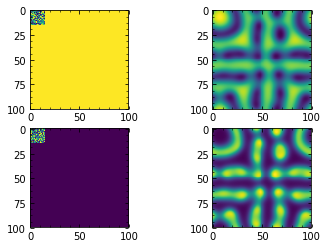

In [16]:
### BEGIN SOLUTION
n_steps = 5000

u = u_ini
v = v_ini
for n in range(n_steps) :
    u, v = grayscott_step(u, v, 1.0, 0.3, 0.03, 0.06, dx, dt)

fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(u_ini)
axs[0,1].imshow(u)
axs[1,0].imshow(v_ini, vmin=np.min(v_ini), vmax=np.max(v_ini))
axs[1,1].imshow(v)
### END SOLUTION

No further work is required for this lab, however below is an image showing what behaviors you might find for different values of $f$ and $k$. Feel free to change these and see if you can produce different behaviors. To produce a similar plot, you can set $k$ and $f$ themselves to be arrays, and vary them across the domain. You can try running the system for longer, varying the resolution, or making other choices; you may need to choose $\Delta t$ carefully so as to maintain stability. There is also an [online implementation](https://mrob.com/pub/comp/xmorphia/ogl/index.html) that allows you to explore different parameter choices interactively.
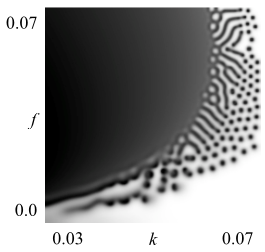

--------------
## Optional: animated plots

We can also animate plots in Jupyter notebooks. Below is an example of how to do this. You may need to modify the code below to work with the function you wrote.

In [5]:
import matplotlib.animation as animation
from IPython.display import HTML

In [17]:
fig = plt.figure()

u = u_ini
v = v_ini
ims = []
n_steps = 20000 # number of steps to take
frame_interval = 200 # steps to take between making plots

# build a list of images
for n in range(n_steps) :
    
    # This may need to be changed, depending on the function you wrote.
    # Here I've chosen slightly different coefficients.
    u, v = grayscott_step(u, v, 1.0, 0.2, 0.19, 0.04, dx, dt)
    
    ## Store frames when n is a multiple of frame_interval
    if n%frame_interval == 0:
        im = plt.imshow(u) # Show a plot of u.
        ims.append([im]) # append single image to the list of images

plt.close()

anim = animation.ArtistAnimation(fig, ims, interval=100, repeat=False)
HTML(anim.to_jshtml())

## Member Participation

See Lab 1 for instructions on turning in labs. In the following cell enter the names for each student in the group who partcipated in this lab.